# Построение прототипа книжного рекомендательного сервиса

# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Установка библиотеки Surprise
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544621 sha256=23fe4106a7c7dfc43028cb9e6e3b07b6f8b2bc14bee78449a30884bb4cd1f6d1
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
# Понижаем numpy до последней версии 1.x (совместимой с surprise)
!pip install "numpy<2.0"

# Перезапускаем среду (обязательно!)
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
print(np.__version__)  # должно быть 1.26.x или подобное

from surprise import Dataset, Reader, SVD, accuracy
print("Surprise успешно импортирован!")

1.26.4
Surprise успешно импортирован!


In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from tqdm import tqdm
from collections import defaultdict
from scipy.sparse import csr_matrix

from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

In [ ]:
# Путь к папке с данными
data_path = '/content/drive/MyDrive/Colab Notebooks/RS/HW/'

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
ratings = pd.read_csv(data_path + 'ratings.csv')
books   = pd.read_csv(data_path + 'books.csv')
tags    = pd.read_csv(data_path + 'tags.csv')
book_tags = pd.read_csv(data_path + 'book_tags.csv')

## EDA (Exploratory Data Analysis)

Посмотрим уникальные значения и статистику

In [ ]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [ ]:
ratings.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:
Уникальные оценки: [1, 2, 3, 4, 5]

Статистика оценок:
count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

 66.2% всех оценок — это 4 или 5.
Средняя оценка: 3.86


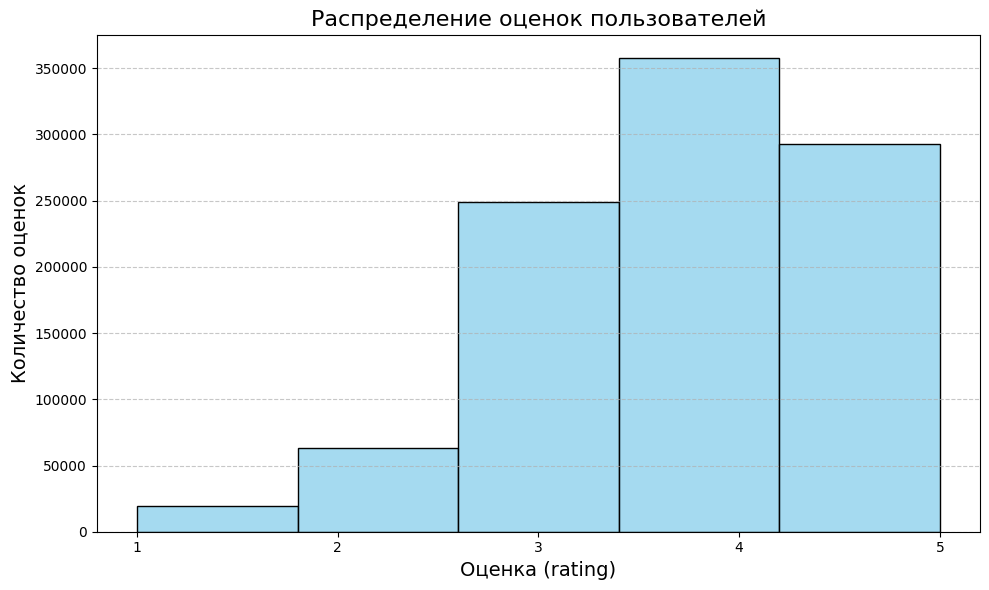


 ИНТЕРПРЕТАЦИЯ:
Распределение сильно смещено в сторону высоких оценок.
Это типично для рекомендательных систем: пользователи чаще
оценивают книги, которые им понравились.

 Минимальная оценка — 1, что говорит о шкале от 1 до 5.


In [ ]:
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:")

# Уникальные значения и статистика
unique_ratings = sorted(ratings['rating'].unique())
print(f"Уникальные оценки: {unique_ratings}")
print("\nСтатистика оценок:")
print(ratings['rating'].describe())

# Процент высоких оценок (4 и 5)
high_ratings = ratings[ratings['rating'] >= 4]
pct_high = len(high_ratings) / len(ratings) * 100
print(f"\n {pct_high:.1f}% всех оценок — это 4 или 5.")

# Среднее значение
mean_rating = ratings['rating'].mean()
print(f"Средняя оценка: {mean_rating:.2f}")

# Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=len(unique_ratings), kde=False, color='skyblue', edgecolor='black')
plt.title('Распределение оценок пользователей', fontsize=16)
plt.xlabel('Оценка (rating)', fontsize=14)
plt.ylabel('Количество оценок', fontsize=14)
plt.xticks(unique_ratings)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Интерпретация
print("\n ИНТЕРПРЕТАЦИЯ:")

if mean_rating > 3.5 and pct_high > 60:
    print("Распределение сильно смещено в сторону высоких оценок.")
    print("Это типично для рекомендательных систем: пользователи чаще")
    print("оценивают книги, которые им понравились.")
else:
    print("Распределение относительно сбалансировано.")

if 0 in unique_ratings:
    print("\n В датасете присутствуют нулевые оценки — возможно, это 'не понравилось' или 'не читал'.")
else:
    print("\n Минимальная оценка — 1, что говорит о шкале от 1 до 5.")

1. Сильное позитивное смещение (positive bias)
66.2% всех оценок — это 4 или 5, что указывает на тенденцию пользователей ставить высокие оценки.
Медиана (50%) = 4, а 75% квантиль = 5 — три четверти всех оценок — 4 или 5.
Минимальная оценка — 1, максимальная — 5, но низкие оценки (1–2) встречаются редко.

2. Высокое среднее значение
Средняя оценка = 3.86 из 5 — это выше нейтрального уровня (3.0).
При равномерном распределении среднее было бы около 3.0, а при симметричном — около 3.5.
Значение 3.86 указывает, что положительных отзывов больше.

 Подсчитаем количество оценок на пользователя.

In [ ]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Для полноты данных, анализа и рекомендаций, а так же упрощения дальнейшей обработки заполним пропуски в original_title значениями из title

In [ ]:
# Заполним пропуски в original_title значениями из title
books['original_title'] = books['original_title'].fillna(books['title'])

In [ ]:
books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [ ]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


Убедимся, что теги не дублируются, оценим разнообразие тегов, подготовим данные для векторизации.

In [ ]:
print(f"Всего уникальных тегов: {tags['tag_name'].nunique()}")

Всего уникальных тегов: 34252


In [ ]:
tags['tag_name'].unique()

array(['-', '--1-', '--10-', ..., 'Ｍａｎｇａ', 'ＳＥＲＩＥＳ', 'ｆａｖｏｕｒｉｔｅｓ'],
      dtype=object)

Проверим корректность ключей для соединения файлов

In [ ]:
print("Столбцы в books:", books.columns.tolist())
print("Столбцы в book_tags:", book_tags.columns.tolist())

Столбцы в books: ['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']
Столбцы в book_tags: ['goodreads_book_id', 'tag_id', 'count']


In [ ]:
# Совпадение между ratings и books (по book_id)
common_books_ratings = len(set(ratings['book_id']) & set(books['book_id']))
print('Совпадающих ID (ratings ↔ books по book_id):', common_books_ratings)

# Совпадение между book_tags и books
common_books_tags = len(set(book_tags['goodreads_book_id']) & set(books['book_id']))
print('Совпадающих ID (book_tags ↔ books по goodreads_book_id = book_id):', common_books_tags)

# Совпадение tag_id между book_tags и tags
common_tags = len(set(book_tags['tag_id']) & set(tags['tag_id']))
print('Совпадающих tag_id (book_tags ↔ tags):', common_tags)

Совпадающих ID (ratings ↔ books по book_id): 812
Совпадающих ID (book_tags ↔ books по goodreads_book_id = book_id): 10000
Совпадающих tag_id (book_tags ↔ tags): 34252



Посмотрим 30 самых популярных тегов в датасете на основе суммарного количества их упоминаний.

Топ-30 самых популярных тегов:
----------------------------------------
 1. to-read                   — 140,718,761
 2. currently-reading         — 7,507,958
 3. favorites                 — 4,503,173
 4. fiction                   — 3,688,819
 5. fantasy                   — 3,548,157
 6. young-adult               — 1,848,306
 7. classics                  — 1,756,920
 8. books-i-own               — 1,317,235
 9. romance                   — 1,231,926
10. owned                     — 1,224,279
11. ya                        — 898,334
12. mystery                   — 872,282
13. non-fiction               — 857,901
14. historical-fiction        — 815,421
15. series                    — 782,637
16. science-fiction           — 703,866
17. sci-fi                    — 597,325
18. paranormal                — 542,559
19. kindle                    — 506,882
20. contemporary              — 486,001
21. book-club                 — 446,685
22. library                   — 429,171
23. favourites            

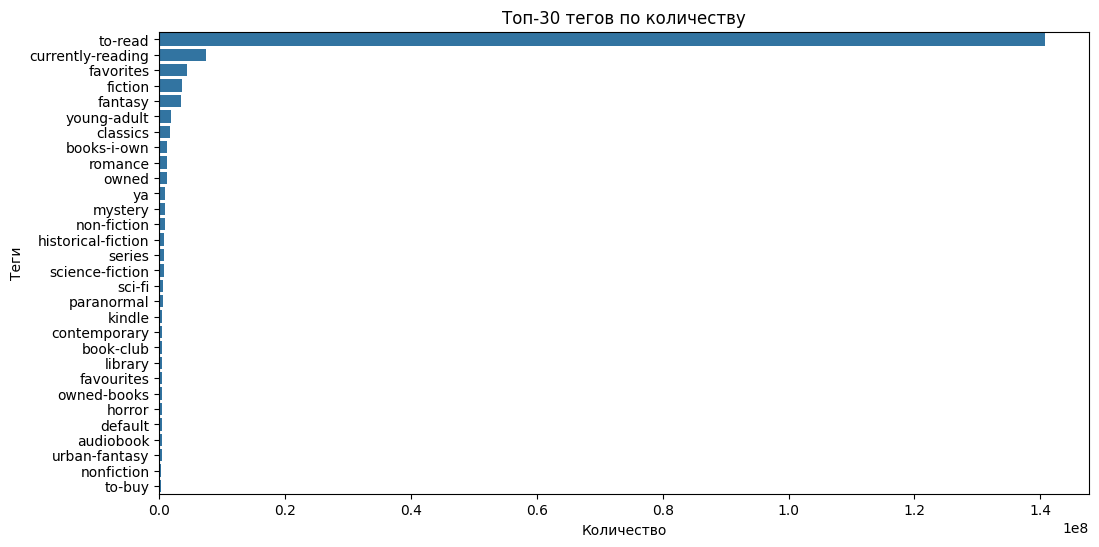

In [ ]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)

print("Топ-30 самых популярных тегов:")
print("-" * 40)
for i, (idx, row) in enumerate(most_common_tags.head(30).iterrows(), 1):
    print(f"{i:2d}. {row['tag_name']:<25} — {int(row['count']):,}")

plt.figure(figsize=(12,6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

Теги вроде to-read и to-buy — это не жанры, а пользовательские заметки. Попробуем их вычестить.

Удалим ненужные теги

In [ ]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains('owned|favorites|currently-reading|series|books-i-own|to-|default|ebook|audiobook|audio|library|book-club|favourites')]
tags

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,ｃhildrens
34248,34248,ｆａｖｏｒｉｔｅｓ
34249,34249,ｍａｎｇａ
34250,34250,ｓｅｒｉｅｓ


Топ-30 самых популярных тегов:
----------------------------------------
 1. fiction                   — 3,688,819
 2. fantasy                   — 3,548,157
 3. young-adult               — 1,848,306
 4. classics                  — 1,756,920
 5. romance                   — 1,231,926
 6. ya                        — 898,334
 7. mystery                   — 872,282
 8. non-fiction               — 857,901
 9. historical-fiction        — 815,421
10. science-fiction           — 703,866
11. sci-fi                    — 597,325
12. paranormal                — 542,559
13. kindle                    — 506,882
14. contemporary              — 486,001
15. horror                    — 415,467
16. urban-fantasy             — 374,689
17. nonfiction                — 371,049
18. adult                     — 337,222
19. classic                   — 334,113
20. childrens                 — 315,716
21. graphic-novels            — 313,560
22. thriller                  — 309,276
23. vampires                  — 300,73

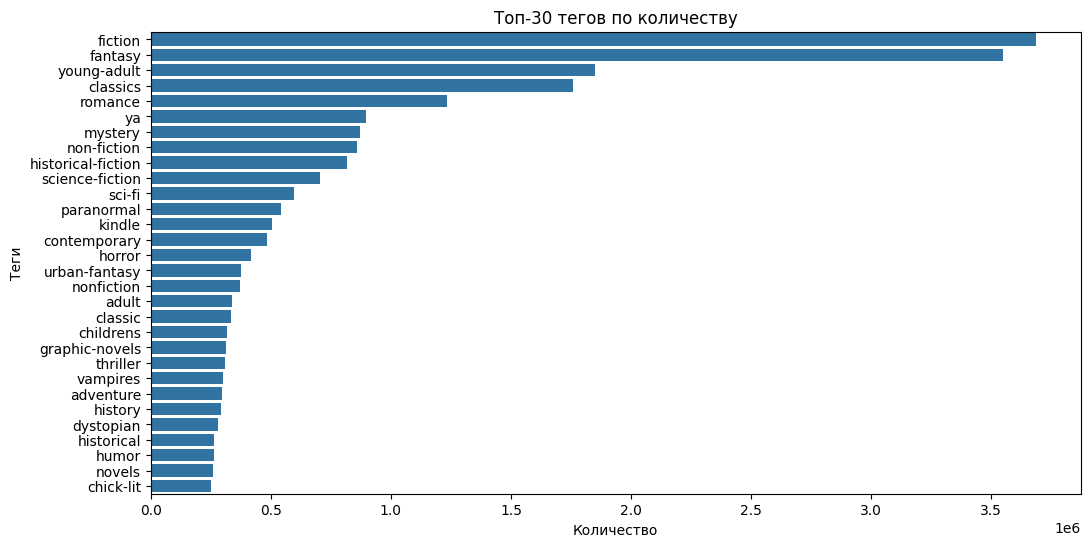

In [ ]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)

print("Топ-30 самых популярных тегов:")
print("-" * 40)
for i, (idx, row) in enumerate(most_common_tags.head(30).iterrows(), 1):
    print(f"{i:2d}. {row['tag_name']:<25} — {int(row['count']):,}")

plt.figure(figsize=(12,6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

Те теги, которые содержат цифры и символы тоже очистим.

In [ ]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=]')]
tags = tags[tags['tag_name'].str.match(r'^[a-zA-Z\s\-]+$')]
tags = tags[~tags['tag_name'].str.match(r'^[-]')]
tags = tags[~tags['tag_name'].str.match(r'[-]$')]
tags = tags[tags['tag_name'].isin(book_tags.merge(tags, on='tag_id', how='inner').groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)['tag_name'].head(10000))]
tags

,tag_id,tag_name
1291,1291,a
1294,1294,a-a-milne
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie
...,...,...
33265,33265,zombie-fiction
33268,33268,zombies
33272,33272,zoo
33275,33275,zoology


Топ-30 самых популярных тегов:
----------------------------------------
 1. fiction                   — 3,688,819
 2. fantasy                   — 3,548,157
 3. young-adult               — 1,848,306
 4. classics                  — 1,756,920
 5. romance                   — 1,231,926
 6. ya                        — 898,334
 7. mystery                   — 872,282
 8. non-fiction               — 857,901
 9. historical-fiction        — 815,421
10. science-fiction           — 703,866
11. sci-fi                    — 597,325
12. paranormal                — 542,559
13. kindle                    — 506,882
14. contemporary              — 486,001
15. horror                    — 415,467
16. urban-fantasy             — 374,689
17. nonfiction                — 371,049
18. adult                     — 337,222
19. classic                   — 334,113
20. childrens                 — 315,716
21. graphic-novels            — 313,560
22. thriller                  — 309,276
23. vampires                  — 300,73

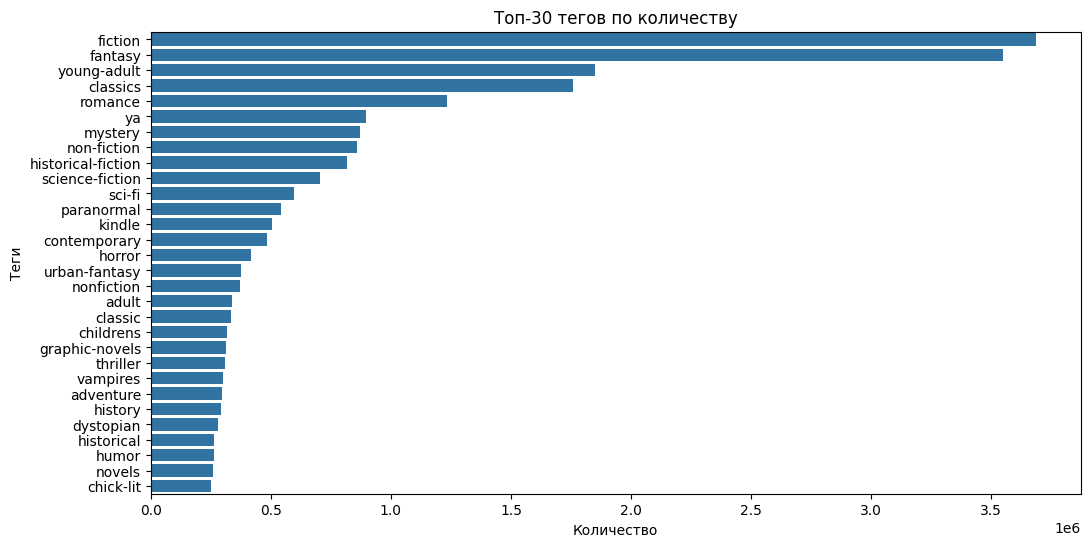

In [ ]:
# Проверим очистку
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)

print("Топ-30 самых популярных тегов:")
print("-" * 40)
for i, (idx, row) in enumerate(most_common_tags.head(30).iterrows(), 1):
    print(f"{i:2d}. {row['tag_name']:<25} — {int(row['count']):,}")

plt.figure(figsize=(12,6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

# Этап 2: базовые и контентные модели

### - Неперсонализированная модель

In [ ]:
book_stats = ratings.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
def get_top_n_popularityular(N=10, min_count=20):
    top = book_stats[book_stats['n_ratings'] >= min_count].sort_values('mean_rating', ascending=False).head(N)
    print('Топ популярных книг')
    return top.merge(books[['book_id','original_title']], on='book_id', how='left')

get_top_n_popularityular(5)

Топ популярных книг


,book_id,mean_rating,n_ratings,original_title
0,7947,4.820225,89,NaN
1,6920,4.780000,100,NaN
2,5207,4.780000,100,NaN
3,9566,4.777778,99,Still Life with Woodpecker
4,8946,4.774194,93,NaN


In [ ]:
def get_top_n_popularityular(N=10, min_count=20):
    # Фильтруем только те книги, что есть в books
    book_ids_in_books = set(books['book_id'])
    filtered_stats = book_stats[book_stats['book_id'].isin(book_ids_in_books)]

    top = filtered_stats[filtered_stats['n_ratings'] >= min_count].sort_values('mean_rating', ascending=False).head(N)
    print('Топ популярных книг (только из books)')
    return top.merge(books[['book_id','original_title']], on='book_id', how='left')

In [ ]:
print("Макс. число оценок у книги:", book_stats['n_ratings'].max())
print("Книг с ≥100 оценками:", (book_stats['n_ratings'] >= 100).sum())
print("Книг с ≥50 оценками:", (book_stats['n_ratings'] >= 50).sum())

Макс. число оценок у книги: 100
Книг с ≥100 оценками: 7456
Книг с ≥50 оценками: 9990


In [ ]:
def get_top_n_popularityular(N=10, min_count=20):
    # Фильтрация по количеству оценок
    filtered = book_stats[book_stats['n_ratings'] >= min_count]
    print(f"Книг с ≥{min_count} оценками: {len(filtered)}")

    # Проверим пересечение с books
    book_ids_in_books = set(books['book_id'])
    filtered_in_books = filtered[filtered['book_id'].isin(book_ids_in_books)]
    print(f"Из них есть в books: {len(filtered_in_books)}")

    top = filtered_in_books.sort_values('mean_rating', ascending=False).head(N)
    print('Топ популярных книг')
    result = top.merge(books[['book_id','original_title']], on='book_id', how='left')
    return result

get_top_n_popularityular(N=5, min_count=100)

Книг с ≥100 оценками: 7456
Из них есть в books: 607
Топ популярных книг


,book_id,mean_rating,n_ratings,original_title
0,4708,4.66,100,The Beautiful and Damned
1,3885,4.55,100,The Taste of Home Cookbook
2,2767,4.54,100,A People's History of the United States: 1492 to Present
3,2865,4.53,100,Girl with a Pearl Earring
4,976,4.50,100,Deception Point


### - Контентная модель

In [ ]:
# Объединяем book_tags с books по соответствующим ID
book_with_tags = book_tags.merge(
    books[['book_id', 'original_title']],
    left_on='goodreads_book_id',
    right_on='book_id',
    how='inner'
).merge(
    tags[['tag_id', 'tag_name']],
    on='tag_id',
    how='inner'
)

# Группируем теги по book_id
book_tags_grouped = book_with_tags.groupby('book_id')['tag_name'].apply(
    lambda tags: ' '.join(sorted(set(tags)))
).reset_index().rename(columns={'tag_name': 'tag_profile'})

# Создаём профили книг
book_profiles = books[['book_id', 'original_title']].merge(
    book_tags_grouped,
    on='book_id',
    how='left'
)
book_profiles['tag_profile'] = book_profiles['tag_profile'].fillna('')
book_profiles['text_profile'] = (
    book_profiles['original_title'].fillna('') + ' ' + book_profiles['tag_profile']
).str.lower()

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_matrix = TfidfVectorizer(
    max_features=20000,
    stop_words='english',
    ngram_range=(1, 2)
).fit_transform(book_profiles['text_profile'])

# Индексы для быстрого доступа
bookid_to_index = {bid: idx for idx, bid in enumerate(book_profiles['book_id'])}
index_to_bookid = {idx: bid for bid, idx in bookid_to_index.items()}

def get_similar_books(book_id, N=5, turn_on_info=True):
    if book_id not in bookid_to_index:
        print(f"Книга с book_id={book_id} не найдена в профилях.")
        return []

    idx = bookid_to_index[book_id]
    sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).ravel()
    original_title = book_profiles[book_profiles['book_id'] == book_id]['original_title'].values[0]
    if pd.isna(original_title):
        original_title = "Unknown Title"
    best_indices = sims.argsort()[::-1]
    results = []

    for i in best_indices:
        bid = int(book_profiles.iloc[i]['book_id'])
        if bid == book_id:
            continue
        title = book_profiles.iloc[i]['original_title']
        if pd.isna(title):
            title = "Unknown Title"
        results.append({
            'book_id': bid,
            'title': title,
            'score': float(sims[i])
        })
        if len(results) >= N:
            break

    if turn_on_info:
        print(f'Похожие книги на "{original_title}":')
        for r in results:
            print(f"  - {r['title']} (score: {r['score']:.4f})")
        return results
    else:
        titles = [r['title'] for r in results]
        print(f'Похожие книги на "{original_title}":')
        for t in titles:
            print(f"  - {t}")
        return titles

# Пример использования
sample_book_id = book_profiles['book_id'].iloc[8]  # корректный способ взять book_id
get_similar_books(sample_book_id, N=5)

Похожие книги на "Angels & Demons ":
  - The Da Vinci Code (score: 0.7651)
  - Digital Fortress (score: 0.7400)
  - The Lost Symbol (score: 0.7202)
  - Deception Point (score: 0.6832)
  - Inferno (score: 0.6718)


[{'book_id': 968, 'title': 'The Da Vinci Code', 'score': 0.7650811421352915},
 {'book_id': 11125, 'title': 'Digital Fortress', 'score': 0.7399699566821571},
 {'book_id': 6411961, 'title': 'The Lost Symbol', 'score': 0.7201933969755475},
 {'book_id': 976, 'title': 'Deception Point', 'score': 0.6831798117828112},
 {'book_id': 17212231, 'title': 'Inferno', 'score': 0.6717702206135213}]

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)

In [ ]:
# Создадим разреженную матрицу взаимодействий «пользователь — книга»
def build_sparse_matrix(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    u2i = {u:i for i,u in enumerate(users)}
    b2i = {b:i for i,b in enumerate(books)}
    rows = df['user_id'].map(u2i)
    cols = df['book_id'].map(b2i)
    data = df['rating'].astype(float)
    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(books)))
    return R, u2i, b2i, users, books

# Предсказание рейтинга пользователя для конкретной книги на основе похожих книг, которые он уже оценил
def predict_item_based(R, u2i, b2i, user_id, target_book_id, K=20):
    if user_id not in u2i or target_book_id not in b2i:
        return ratings['rating'].mean()
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    uidx = u2i[user_id]
    tidx = b2i[target_book_id]
    sims = item_user_norm.dot(item_user_norm[tidx].T).toarray().ravel()
    user_rated = R[uidx].nonzero()[1]
    if len(user_rated) == 0:
        return ratings['rating'].mean()
    rated_sims = [(i, sims[i]) for i in user_rated]
    rated_sims = sorted(rated_sims, key=lambda x: x[1], reverse=True)[:K]
    num = 0.0; den = 0.0
    for i,s in rated_sims:
        r = R[uidx, i]
        num += s * r
        den += abs(s)
    return float(num/den) if den != 0 else ratings['rating'].mean()

# Делает топ-N рекомендаций книг пользователю
def itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id, N=10, K=20):
    if user_id not in u2i:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    uidx = u2i[user_id]
    user_rated_indices = R[uidx].nonzero()[1]
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    agg = np.zeros(len(books_arr))
    if len(user_rated_indices) == 0:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# Применение
R, u2i, b2i, users_arr, books_arr = build_sparse_matrix(ratings)
print(f'Ожидаемый рейтинг пользователя 99 для книги 100: {predict_item_based(R, u2i, b2i, user_id=99, target_book_id=100)}')
print('Рекомендованные книги:', itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id=123, N=5))

Ожидаемый рейтинг пользователя 99 для книги 100: 3.8565335989797873
Рекомендованные книги: [7721, 6293, 7610, 7566, 7698]


Сложность состоит в следующем:

Построение нормализованной матрицы: $O(U × B)$
Предсказание для одной книги: $O(B)$ — из-за полного умножения вектора
Генерация топ-N рекомендаций: $O(B²)$ — из-за агрегации по всем оценённым книгам
→ Немасштабируемо при $B > 10⁵$.

Возможность оптимизации:

Кэшировать матрицу сходств между книгами (или её приближение).
Использовать приближённый поиск ближайших соседей (ANN):
Faiss, Annoy, scikit-learn NearestNeighbors
Предварительно вычислить топ-K похожих книг для каждой книги и хранить только их.
Использовать неявный feedback (0/1) вместо явных оценок — упрощает вычисления.


# Этап 4: матричные разложения (Matrix Factorization)

In [ ]:
# Настройка reader
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

# Разделение на train/test
trainset_s, testset_s = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)

# Обучение модели SVD
algo = SVD(n_factors=120, n_epochs=25, lr_all=0.005, reg_all=0.02, random_state=42)
algo.fit(trainset_s)

# Оценка качества
preds = algo.test(testset_s)
print('RMSE:', accuracy.rmse(preds))

# Функция рекомендаций
def get_recommendations(user_id, N=5):
    # Все книги, которые пользователь ещё не оценил
    rated_books = set(ratings[ratings['user_id'] == user_id]['book_id'])
    all_books = set(ratings['book_id'].unique())
    books_for_rec = list(all_books - rated_books)

    if not books_for_rec:
        return []

    # Предсказание рейтинга для каждой книги
    predictions = [algo.predict(uid=user_id, iid=book_id) for book_id in books_for_rec]
    # Сортировка по предсказанному рейтингу
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Формирование рекомендаций
    recs = []
    for pred in predictions[:N]:
        title = books.loc[books['book_id'] == pred.iid, 'original_title'].values
        title = title[0] if len(title) > 0 else "Нет названия"
        recs.append({
            'book_id': int(pred.iid),
            'title': title,
            'pred_rating': round(pred.est, 3)
        })
    return recs

# Прменение
user_id = 99
recommendations = get_recommendations(user_id, N=5)

print(f"Рекомендации для пользователя {user_id}:")
for r in recommendations:
    print(f"- {r['title']} (book_id={r['book_id']}, предсказанный рейтинг={r['pred_rating']})")

RMSE: 0.8442
RMSE: 0.8442120287269222
Рекомендации для пользователя 99:
- Нет названия (book_id=3628, предсказанный рейтинг=4.926)
- Нет названия (book_id=4483, предсказанный рейтинг=4.777)
- Нет названия (book_id=5207, предсказанный рейтинг=4.746)
- Нет названия (book_id=1788, предсказанный рейтинг=4.736)
- Нет названия (book_id=562, предсказанный рейтинг=4.733)


# Этап 5: оценка и сравнение моделей

In [ ]:
# Разбиение на train/test
def train_test_split(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list=[]; test_list=[]
    for uid, g in df.groupby('user_id'):
        n = len(g)
        if n < 2:
            train_list.append(g)
            continue
        test_n = max(1, int(n * test_size))
        test_idx = np.random.choice(g.index, size=test_n, replace=False)
        test_list.append(g.loc[test_idx])
        train_list.append(g.drop(test_idx))
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split(ratings, test_size=0.2, seed=42)
print('Размеры train/test')
print(f'train - {len(train_df)}, test - {len(test_df)}')

user_relevant = test_df[test_df['rating'] >= 4].groupby('user_id')['book_id'].apply(set).to_dict()

Размеры train/test
train - 790350, test - 191406


In [ ]:
# Popularity-рекомендатель
book_stats_train = train_df.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
popular_books_train = book_stats_train[book_stats_train['n_ratings']>=20].sort_values('mean_rating', ascending=False)

def popularity_recommender(user_id, N=10):
    return popular_books_train.head(N)['book_id'].astype(int).tolist()

In [ ]:
# Content-based рекомендатель
def content_recommender(user_id, N=10):
    seen = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if not seen:
        return popularity_recommender(user_id, N)
    sims = np.zeros(tfidf_matrix.shape[0], dtype=float)
    seen_idxs = [bookid_to_index[b] for b in seen if b in bookid_to_index]
    if not seen_idxs:
        return popularity_recommender(user_id, N)
    for si in seen_idxs:
        sims += cosine_similarity(tfidf_matrix[si], tfidf_matrix).ravel()
    sims /= max(1, len(seen_idxs))
    ranked = np.argsort(sims)[::-1]
    recs = []
    for idx in ranked:
        bid = int(book_profiles.loc[idx, 'book_id'])
        if bid in seen:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

In [ ]:
# ItemCF
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=20):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)
    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)
    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

In [ ]:
# SVD (с использованием Surprise)
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

algo = SVD(n_factors=300, n_epochs=50, lr_all=0.004, reg_all=0.01, random_state=42)
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df['book_id'].unique()
    seen_train = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if (user_id not in set(train_df['user_id'])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)
    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=b).est
        except Exception:
            est = train_df['rating'].mean()
        preds.append((int(b), float(est)))
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]

In [ ]:
# Метрики качества
def precision_at_k(rec, rel, k=10):
    if not rec: return 0.0
    return len(set(rec[:k]) & set(rel)) / k

def recall_at_k(rec, rel, k=10):
    if not rel: return 0.0
    return len(set(rec[:k]) & set(rel)) / len(rel)

def ndcg_at_k(rec, rel, k=10):
    dcg = 0.0
    for i, r in enumerate(rec[:k]):
        if r in rel:
            dcg += 1.0 / np.log2(i+2)
    ideal = sum(1.0 / np.log2(i+2) for i in range(min(len(rel), k)))
    return dcg/ideal if ideal>0 else 0.0

In [ ]:
# Оценка всех моделей
models = {
    'Popularity': popularity_recommender,
    'Content': content_recommender,
    'ItemCF': itemcf_recommender,
    'SVD': svd_recommender
}

results = []
for name, rec_fn in models.items():
    precs = []
    recs_ = []
    ndcgs = []

    print(f"Оценка модели: {name}")
    for uid in tqdm(list(user_relevant.keys())[:1000], desc=f"{name}", leave=False):
        rel = user_relevant.get(uid, set())
        if not rel:
            continue
        recs_list = rec_fn(uid, N=10)
        precs.append(precision_at_k(recs_list, rel, 10))
        recs_.append(recall_at_k(recs_list, rel, 10))
        ndcgs.append(ndcg_at_k(recs_list, rel, 10))

    results.append({
        'model': name,
        'precision@10': np.mean(precs) if precs else 0.0,
        'recall@10': np.mean(recs_) if recs_ else 0.0,
        'nDCG@10': np.mean(ndcgs) if ndcgs else 0.0,
        'n_users': len(precs)
    })

metrics_df = pd.DataFrame(results).set_index('model')
metrics_df

Оценка модели: Popularity


Оценка модели: Content


Оценка модели: ItemCF


Оценка модели: SVD


,precision@10,recall@10,nDCG@10,n_users
model,,,,
Popularity,0.0005,0.001195,0.001151,1000
Content,0.0001,0.000500,0.000613,1000
ItemCF,0.0476,0.197568,0.152636,1000
SVD,0.0004,0.000954,0.000570,1000


- ItemCF - Лучшая отработка среди моделей.

- Precision@10 = 4.76%, из 10 рекомендаций в среднем ~0.5 книги действительно релевантны (оценка ≥ 4).

- Recall@10 = 19.76%, модель находит почти 1 из 5 релевантных книг из тестового набора.

- nDCG@10 = 0.153 — учитывает ранжирование; значение выше других, но всё ещё низкое (максимум = 1).

- Popularity: рекомендует одни и те же книги всем игнорирует индивидуальные предпочтения.

- Content: основан на тегах и названиях,
но теги в основном — поведенческие (to-read, owned), а не тематические.

- SVD: возможно, недостаточно данных на пользователя (разреженная матрица).


# Этап 6: гибридизация и выводы

1. Гибритизация.

 Гибридный подход можно реализовать путем — объединия преимущества нескольких методов (например, коллаборативной фильтрации и контент-базированных моделей), чтобы:

- Компенсировать слабости отдельных подходов (например, холодный старт у CF и низкая персонализация у content-based).
- Повысить точность и устойчивость рекомендаций.
- Обеспечить покрытие как новых, так и известных сущностей (пользователей и книг).
- Использовать матричную факторизацию с контекстом (например, LightFM).

2. Выводы по работе.

- Item-Based Collaborative Filtering работает корректно и использует поведенческие паттерны пользователей эффективно.

Остальные модели практически не отработали.
Popularity, Content, SVD имеют низкие метрики, чем ItemCF, они практически не дают релевантных рекомендаций.

- Улучшение системы:

Заменить/очистить теги: удалить to-read, owned, оставить только жанры и темы.

Использовать современные эмбеддинги:
Word2Vec / FastText для названий,
Sentence-BERT для описаний.

Улучшить SVD: попробовать ALS, implicit BPR, LightFM (гибридная модель с признаками).

Гибридизация
Объединить ItemCF и Content-based через взвешенное суммирование или стекинг.
Использовать матричную факторизацию с контекстом (например, LightFM).

Ввести метрики разнообразия и покрытия (coverage), чтобы избежать перекоса в бестселлеры.


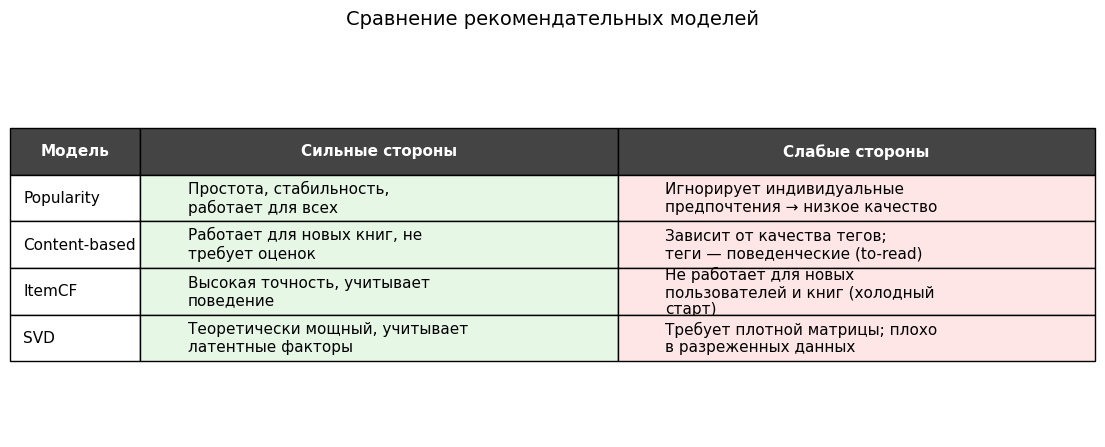